# An analysis of algorithms for conversion rate prediction
## A case study by:
- U Aaditya - CB.EN.U4CSE18402
- K V Phanindra Reddy - CB.EN.U4CSE18433
- N S S S Rohit Kallakuri - CB.EN.U4CSE18449

First, we import the dataset:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

df=pd.read_csv('conversion_data.csv')

Let's see what the dataset looks like:

In [2]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
df.tail()

,country,age,new_user,source,total_pages_visited,converted
316195,US,26,1,Ads,9,0
316196,US,27,1,Direct,6,0
316197,China,25,0,Ads,4,0
316198,US,22,0,Seo,4,0
316199,UK,24,0,Ads,4,0


In [4]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


## Preprocessing

There are some fake values for age here, as made evident by the max value of age at 123. Let's see how many unrealistic ages are there:

In [5]:
sorted(df['age'],reverse=True)[:25]

[123,
 111,
 79,
 77,
 73,
 72,
 70,
 70,
 69,
 69,
 69,
 68,
 68,
 68,
 68,
 68,
 67,
 67,
 67,
 67,
 67,
 66,
 66,
 66,
 66]

Luckily, we only have 2 unrealistic values, and they can be removed easily. Let' get rid of them now:

In [6]:
print(df.loc[df['age']==123])
print(df.loc[df['age']==111])

       country  age  new_user source  total_pages_visited  converted
90928  Germany  123         0    Seo                   15          1
       country  age  new_user source  total_pages_visited  converted
295581      UK  111         0    Ads                   10          1


In [7]:
df.drop([90928,295581],inplace=True)

Now, let's see if the dataset has any null values:

In [8]:
df.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

Luckily, we don't have any null values.

## Data Visualization

Now, let's try to visualize the dataset. Let's see the demographic of the people who have converted:

<AxesSubplot:xlabel='country', ylabel='converted'>

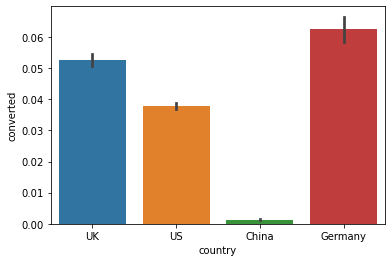

In [9]:
sns.barplot(x='country',y='converted',data=df)

With this, we can infer that the conversion rate in China is way lower than that in countries like the USA, UK and Germany.

Now let's take a look at the proportion of people getting converted from each source

In [10]:
pie_data=df.groupby('source')['converted'].sum()
pie_data

source
Ads       3059
Direct    2040
Seo       5099
Name: converted, dtype: int64

<AxesSubplot:ylabel='converted'>

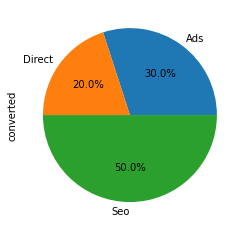

In [11]:
pie_data.plot.pie(autopct="%.1f%%")

From this, we can infer that roughly 50% of the conversions happen through SEO marketing.

Now let's try to visualize the trend in conversion rate with number of pages visited:

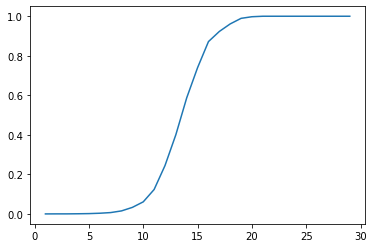

In [12]:
data_pages = df.groupby('total_pages_visited')[['converted']].mean()
data_ages = df.groupby('age')[['converted']].mean()
plt.plot(data_pages.index,data_pages['converted'])

The x axis here is number of pages visited, and the y axis is conversion rate. We can see that as the number of pages increases, the conversion rate increases too

Now, let's try to visualize the effect of age on conversion rate:

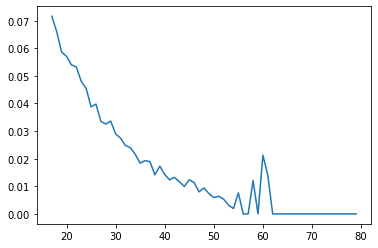

In [13]:
plt.plot(data_ages.index,data_ages['converted'])

This shows a inverse proportionality between age and conversion rate - the higher the age, the lower the conversion.

## Training the Random Forest Classifier

Now let's train a random forest classifier. For that, let's make a copy of the original dataframe, apply one hot encoding on the countries and source, split the dataset and train the model:

In [14]:
df2=df
df_country = pd.get_dummies(df2['country'])
df2 = pd.concat([df2, df_country], axis=1)
df_source = pd.get_dummies(df2['source'])
df2 = pd.concat([df2, df_source], axis=1)
df2.head()

,country,age,new_user,source,total_pages_visited,converted,China,Germany,UK,US,Ads,Direct,Seo
0,UK,25,1,Ads,1,0,0,0,1,0,1,0,0
1,US,23,1,Seo,5,0,0,0,0,1,0,0,1
2,US,28,1,Seo,4,0,0,0,0,1,0,0,1
3,China,39,1,Seo,5,0,1,0,0,0,0,0,1
4,US,30,1,Seo,6,0,0,0,0,1,0,0,1


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df2[['total_pages_visited','China','Germany','UK','US','Ads','Direct','Seo','age','new_user']], df2['converted'], test_size=0.33, random_state=42)

Now that we have split the dataset, let's train the model:

In [16]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, np.array(y_train))

RandomForestClassifier(random_state=42)

In [17]:
print('The accuracy of the random forest classifier model is',str(forest.score(X_test,y_test)*100)+'%')

The accuracy of the random forest classifier model is 98.50209878672877%


In [18]:
print('The baseline accuracy is '+str(100*(1-sum(df2['converted'])/len(df2['converted'])))+'%')

The baseline accuracy is 96.77480565974484%


In [19]:
from sklearn.metrics import confusion_matrix
confusionmatrixforest=confusion_matrix(y_test,forest.predict(X_test))

## Training the KNN classifier:

Now let's train the KNN classifier. For that, let's encode the labels and then split the model and train it:

In [20]:
from sklearn.preprocessing import LabelEncoder
df3=df
le=LabelEncoder()
df3['country']=le.fit_transform(df3['country'])
df3['source']=le.fit_transform(df3['source'])

In [21]:
df3.head()

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,0,1,0
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


In [22]:
df3.tail()

,country,age,new_user,source,total_pages_visited,converted
316195,3,26,1,0,9,0
316196,3,27,1,1,6,0
316197,0,25,0,0,4,0
316198,3,22,0,2,4,0
316199,2,24,0,0,4,0


LabelEncoder encodes the data in ascending alphabetical order like this:

Country: 0-China, 1-Germany, 2-UK, 3-US
Source: 0-Ads, 1-Direct, 2-SEO

Now let's split the dataset:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df3[['total_pages_visited','country','source','age','new_user']], df3['converted'], test_size=0.33, random_state=42)

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)

knn_model.fit(X_train,np.array(y_train))

KNeighborsClassifier(n_neighbors=3)

In [25]:
print('The accuracy of the KNN model is '+str(100*knn_model.score(X_test,y_test))+'%')

The accuracy of the KNN model is 98.4388476798344%


## Training the Naive Bayes classifier:

Now let's train the Naive Bayes classifier. For this we will be using Gaussian NB model in sklearn while also reusing the label encoded training and testing data used in KNN:

In [26]:
from sklearn.naive_bayes import GaussianNB

nb_model=GaussianNB()
nb_model.fit(X_train,np.array(y_train))

GaussianNB()

In [27]:
print('The accuracy of the Naive Bayes model is '+str(100*nb_model.score(X_test,y_test))+'%')

The accuracy of the Naive Bayes model is 98.38613842408908%


## Training the Support Vector classifier:

Now let's train the support vector classifier. For this we will be using the same label encoded training and testing data used in KNN:

In [28]:
from sklearn.svm import SVC

svc_model=SVC(kernel='linear')
svc_model.fit(X_train,np.array(y_train))

SVC(kernel='linear')

In [29]:
print('The accuracy of the SVC model is '+str(100*svc_model.score(X_test,y_test)))

The accuracy of the SVC model is 98.6190174994729


Now, let's deploy the models we created into pickle files:

In [30]:
import pickle
pickle.dump(svc_model, open('svc_model.pkl','wb'))
pickle.dump(nb_model, open('nb_model.pkl','wb'))
pickle.dump(knn_model, open('knn_model.pkl','wb'))
pickle.dump(forest, open('forest_model.pkl','wb'))

In [31]:
knn_model.predict([[2,25,1,0,1]])

array([0], dtype=int64)

In [32]:
confusionmatrixknn=confusion_matrix(y_test,knn_model.predict(X_test))
confusionmatrixnb=confusion_matrix(y_test,nb_model.predict(X_test))
confusionmatrixsvc=confusion_matrix(y_test,svc_model.predict(X_test))

In [33]:
confusionmatrixforest

array([[100488,    541],
       [  1022,   2295]], dtype=int64)

In [34]:
confusionmatrixknn

array([[100463,    566],
       [  1063,   2254]], dtype=int64)

In [35]:
confusionmatrixnb

array([[100079,    950],
       [   734,   2583]], dtype=int64)

In [36]:
confusionmatrixsvc

array([[100684,    345],
       [  1096,   2221]], dtype=int64)